# Medical Image Segmentation: Shape

In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# change to relevant directory
root_path = 'gdrive/My Drive/KU/MIA'  #change dir to your project folder
os.chdir(root_path)

Please first check if matplotlib, sklearn, glob, re, PIL, and scipy packages are installed. Shape analysis can be very useful in medical image segmentation, especially when working with organs that have well-defined shapes, for example, lung fields, vertebrae, etc. It can be used as it is or in combination with other segmentation methods. This exercise will train you to generate a shape model for a human organ using manually annotated reference samples.

The following code shows how to read chest X-rays, and landmarks that annotate each lung field. It also shows how to visualize the landmarks.

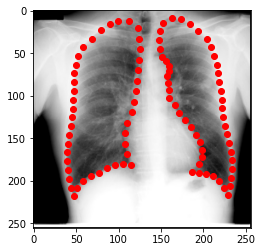

In [193]:
import matplotlib.pyplot as plt
#from IPython.display import clear_output
from scipy.spatial import procrustes
from math import atan
from math import sqrt
import sklearn
import glob
from PIL import Image
import numpy as np
import re
%matplotlib inline 

def parseFile(fileName):
    objects = {}
    pattern = re.compile("[-+]?\d*\.\d+|\d+")
    points = []
    currentName = ''
    f = open(fileName, 'r')
    lines = f.readlines()
    for line in lines:
        if '  [Label=' in line:
            if currentName != '':
                objects[currentName] = points
            points = []
            currentName = line[9:-2]
        if line[0:4] == '  { ':
            splitted = re.findall(r"[-+]?\d*\.\d+|\d+", line)
            points.append([float(splitted[0]), float(splitted[1])])
    objects[currentName] = points
    return objects
        
def readBothLungFields(fileName, scaler = 4):
    objects = parseFile(fileName)
    lungs = np.concatenate((np.asarray(objects['right lung']),
                            np.asarray(objects['left lung']))) / scaler
    return lungs

def readCompleteDatabase(dataFolder):
    database = {}
    files = glob.glob(dataFolder + 'fold1/landmarks/*.pfs')
    for file in files:
        caseName = os.path.split(file)[1][:-4]
        im = Image.open(dataFolder + 'images/' + caseName + '.bmp')
        pIm = np.array(im)[:, :, 0]
        databaseElement = {}
        databaseElement['points'] = readBothLungFields(file)
        databaseElement['image'] = im
        database[caseName] = databaseElement
    return database

def main():
    database = readCompleteDatabase('Data2/scratch/')
    plt.scatter(database['JPCLN001']['points'][:, 0], database['JPCLN001']['points'][:, 1], c = 'r')
    plt.imshow(database['JPCLN001']['image'], cmap='gray')
    
main()

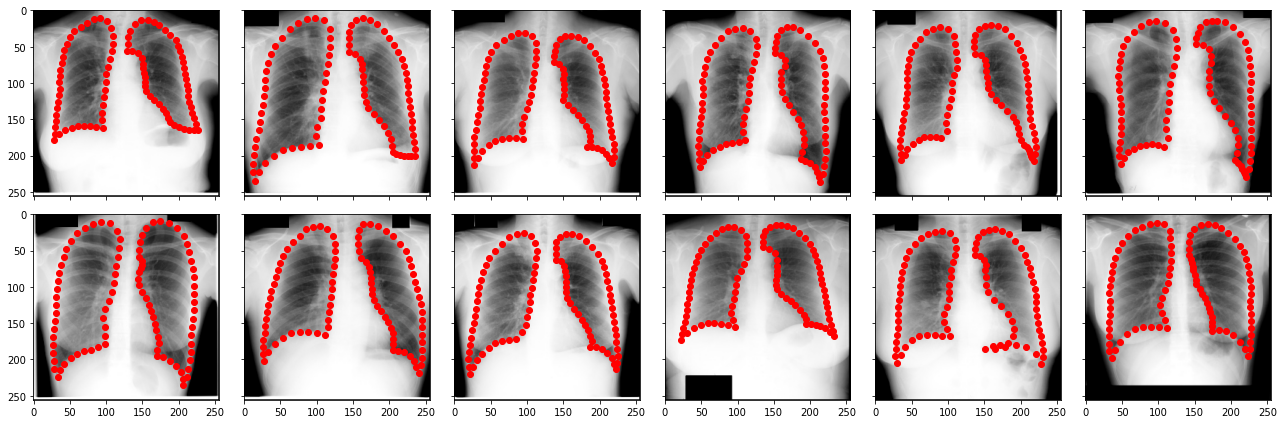

In [6]:
# Visualize some image and points
database = readCompleteDatabase('Data2/scratch/')
keys = [k for k in database.keys()]

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(18,6), sharex=True, sharey=True)
for (ax, k) in zip(axes.flatten(), keys):
  ax.scatter(database[k]['points'][:, 0], database[k]['points'][:, 1], c = 'r')
  ax.imshow(database[k]['image'], cmap='gray')
  fig.tight_layout()
plt.show()

# Procrustes

Exercise 1.1. Implement a Procrustes analysis to align lung field shapes. Visualize some of a pair of lung fields before and after Procrustes-based alignment.

Be sure to correctly implement normalization of the scale, translation, and rotation for the shape model before segmentation with active shape models. Do not forget to save scale factors in the database.

NOTE: you should implement the removal of translation, rotation, and scaling yourself without using any libraries except numpy.

In [187]:
# Select a couple of pairs of lung field shapes

points1 = database[keys[1]]['points'][:,:]
points2 = database[keys[2]]['points'][:,:]

points3 = database[keys[3]]['points'][:,:]
points4 = database[keys[4]]['points'][:,:]

points1.shape, points2.shape

JPCLN045 JPCLN069


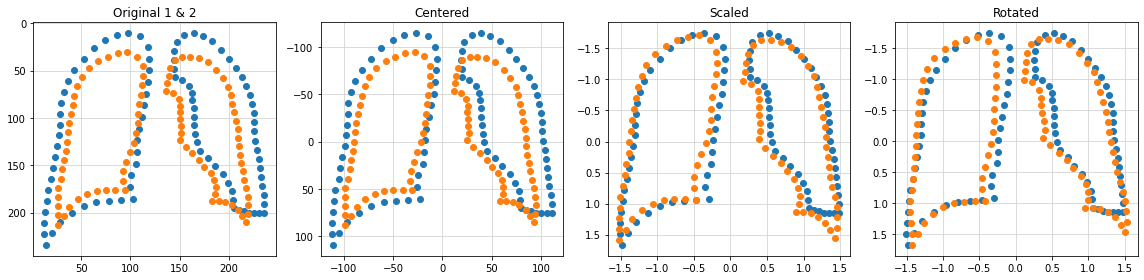

Procrustes distance: 1.3351238936055665
Procrustes distance: 0.9858694946102842


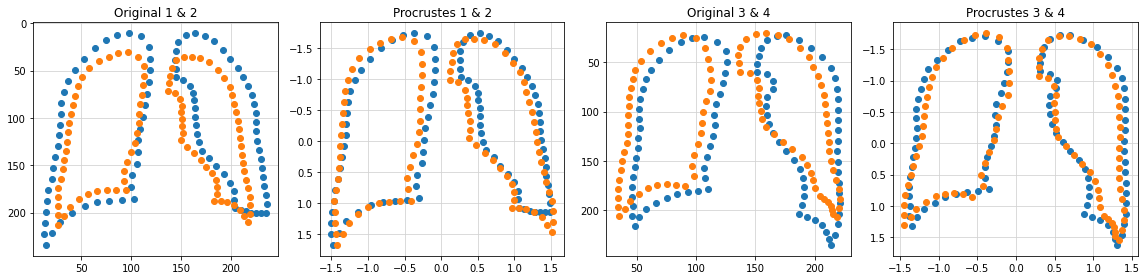

In [195]:
# Implement removal of translation
def translate(x):
  x = x - np.mean(x)
  return x

# Implement removal of scaling
def scale(x):
  scale = sum(x**2 / x.shape[0])**0.5
  return x / scale

# Implement removal of rotation
def get_theta(template, points):
  numerator = sum(points[:, 0] * template[:, 1] - points[:, 1] * template[:, 0])
  divisor = sum(points[:, 0] * template[:, 0] + points[:, 1] * template[:, 1])
  # Avoiding dividing by zero
  if divisor == 0.0:
    divisor = 0.00000000001
  return atan(numerator / divisor)

def rotate(points, theta):
  rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                              [np.sin(theta), np.cos(theta)]])
  return np.dot(rotation_matrix, points.transpose()).transpose()

# Implement procrustes
def procrustes_analysis(template, points, list_points=False):
  template = scale(translate(template))
  if list_points==False:
    points = scale(translate(points))
    theta = get_theta(template, points)
    points = rotate(points, theta)
    print("Procrustes distance:", np.sum((template - points)**2)**0.5)
    return template, points
  else:
    list_points = [template]
    for array in points:
      array = scale(translate(array))
      theta = get_theta(template, array)
      array = rotate(array, theta)
      list_points.append(array)
    return tuple(list_points)

## Visualize the results
def visualize_pairs(imgs, titles=None, grid=True, nrows=1, ncols=2, figsize=(8,4)):
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  for i, (ax, img_tuple) in enumerate(zip(axes.flatten(), imgs)):
    ax.scatter(img_tuple[0][:,0], img_tuple[0][:,1], zorder=2)
    ax.scatter(img_tuple[1][:,0], img_tuple[1][:,1], zorder=2)
    ax.invert_yaxis()
    if grid == True:
        ax.grid(zorder=0, color="lightgray")
    if titles != None:
      ax.set_title(titles[i])
  fig.tight_layout()
  plt.show()

# Visualize the steps for the first pair of lung field shapes
theta = get_theta(scale(translate(points1)), scale(translate(points2)))
imgs = [(points1, points2), 
        (translate(points1), translate(points2)),
        (scale(translate(points1)), scale(translate(points2))),
        (scale(translate(points1)), rotate(scale(translate(points2)),theta))]
titles = "Original 1 & 2", "Centered", "Scaled", "Rotated"
visualize_pairs(imgs, titles, nrows=1, ncols=4, figsize=(16,4))

# Visualize the two pairs before and after the procrustes
points1_proc, points2_proc = procrustes_analysis(points1, points2)
points3_proc, points4_proc = procrustes_analysis(points3, points4)
imgs = (points1, points2), (points1_proc, points2_proc), (points3, points4), (points3_proc, points4_proc)
titles = "Original 1 & 2", "Procrustes 1 & 2", "Original 3 & 4", "Procrustes 3 & 4"
visualize_pairs(imgs, titles, ncols=4, figsize=(16,4))

# Principal component analysis

Exercise 1.2. Implement PCA for modeling the shape of lung fields. Generate illustrations of the mean lung field shape, lung field shape +-3 * sqrt(eigenvalue) for three first eigenval

Compute PCA for lung shape and generate different lung field variations

Shape stacked shapes (94, 2, 124)
Shape stacked shapes reshaped for PCA (188, 124)
Shape mean stacked shapes (188,)
Sigma (188, 188)
Eigvals shape = (188,), eigvect shape = (188, 188)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


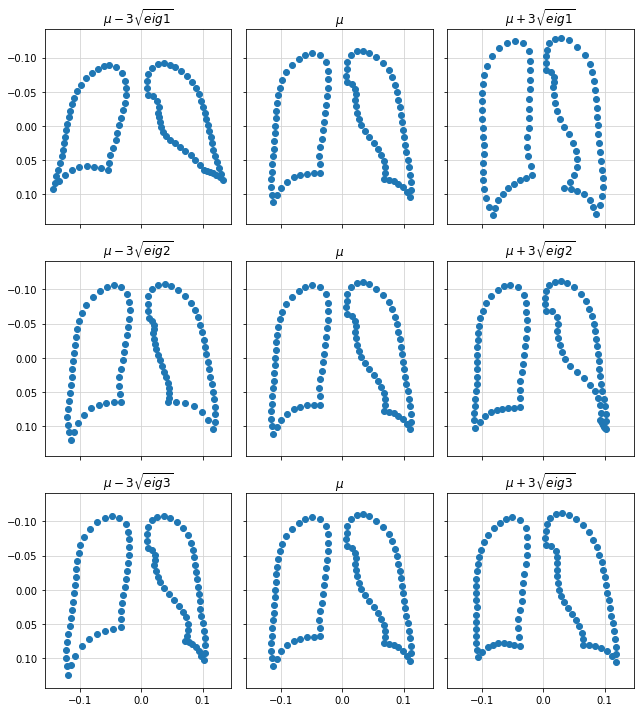

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: ComplexWarning: Casting complex values to real discards the imaginary part


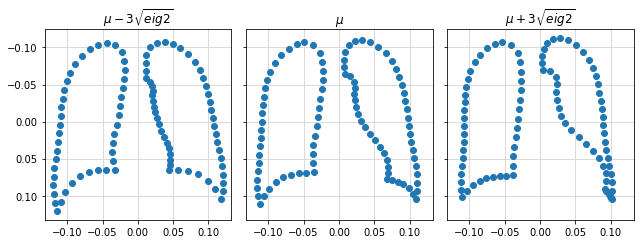

In [249]:
## Visualize 3x3 table with image. The midcolumn should contain the mean lung shape. 

# Apply procrustes to all JPCLN001 lung field shape
l_points = [database[k]['points'][:,:] for k in database.keys()]
#proc_points = procrustes_analysis(l_points[0], l_points[1:], list_points=True)
proc_points = [procrustes(l_points[0], l_points[i])[1] for i in range(len(l_points))]

# Stack them into a 3D tensor
stack_points = np.dstack(proc_points)
print(f"Shape stacked shapes {stack_points.shape}")

# Reshape the 3D tensor for PCA
stack_reshape = np.concatenate((stack_points[:,0,:], stack_points[:,1,:]))
print(f"Shape stacked shapes reshaped for PCA {stack_reshape.shape}")

# # Obtain the mean lung field shape
mean_points = np.mean(stack_reshape,1)
print(f"Shape mean stacked shapes {mean_points.shape}")

# Perform PCA
sigma = np.cov(stack_reshape)
evals, evecs = np.linalg.eig(sigma)
print("Sigma", sigma.shape)
print(f"Eigvals shape = {evals.shape}, eigvect shape = {evecs.shape}")

# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,10), sharex=True, sharey=True)

for (ax, i) in zip(axes.flatten(), range(3)):
  mean_points_tmp1 = mean_points - 3 * sqrt(evals[i]) * evecs[:,i]
  mean_points_tmp2 = mean_points + 3 * sqrt(evals[i]) * evecs[:,i]
  axes[i,0].scatter(mean_points_tmp1[:94], mean_points_tmp1[94:], zorder=2)
  axes[i,0].set_title("$\mu - 3 \sqrt{eig %d}$" % (i+1))
  axes[i,1].scatter(mean_points[:94], mean_points[94:], zorder=2)
  axes[i,1].set_title("$\mu$")
  axes[i,2].scatter(mean_points_tmp2[:94], mean_points_tmp2[94:], zorder=2)
  axes[i,2].set_title("$\mu + 3 \sqrt{eig %d}$" % (i+1))
  for j in range(3):
    axes[j,i].invert_yaxis()
    axes[j,i].grid(zorder=0, color="lightgray")
fig.tight_layout()
plt.show()

# # The left column should define the combination of the mean shape 
# #                  and -3 * sqrt(eigenvalue) eigenvector for the first three eigenvectors
# # The right column should define the combination of the mean shape 
# #                  and +3 * sqrt(eigenvalue) eigenvector for the first three eigenvectors


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,3.5), sharex=True, sharey=True)
mean_points_tmp1 = mean_points - 3 * sqrt(evals[1]) * evecs[:,1]
mean_points_tmp2 = mean_points + 3 * sqrt(evals[1]) * evecs[:,1]
axes[0].scatter(mean_points_tmp1[:94], mean_points_tmp1[94:], zorder=2)
axes[0].set_title("$\mu - 3 \sqrt{eig 2}$")
axes[1].scatter(mean_points[:94], mean_points[94:], zorder=2)
axes[1].set_title("$\mu$")
axes[2].scatter(mean_points_tmp2[:94], mean_points_tmp2[94:], zorder=2)
axes[2].set_title("$\mu + 3 \sqrt{eig 2}$")
for j in range(3):
  axes[j].invert_yaxis()
  axes[j].grid(zorder=0, color="lightgray")
fig.tight_layout()
plt.savefig("./Week3/plots_handin2/PCA.png", dpi=300)
plt.show()

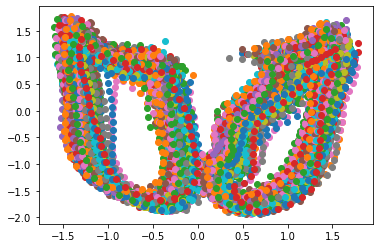

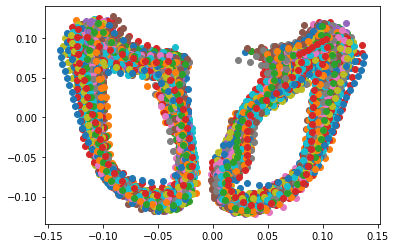

In [217]:
# proc_points_my = procrustes_analysis(l_points[0], l_points[1:], list_points=True)
# proc_points = [procrustes(l_points[0], l_points[i])[1] for i in range(len(l_points))]

# for field in proc_points_my:
#   plt.scatter(field[:,0], field[:,1])
# plt.show()

# for field in proc_points:
#   plt.scatter(field[:,0], field[:,1])
# plt.show()

$\theta$
